# Simulación de Gestión de Inventario en una Tienda
[Ejemplo 7.6 del libro "Simulation, Fifth Edition by Sheldon M. Ross"]

### _*Situación:*_ 
Una tienda vende un producto a un precio fijo por unidad. Los clientes llegan según un proceso Poisson y demandan cantidades aleatorias. La tienda utiliza una política de inventario (s, S) para reponer stock cuando el nivel es bajo.

### _*Objetivos:*_

- Estimar el beneficio esperado hasta un tiempo T

- Evaluar políticas de inventario óptimas


### 1. Definir Parámetros y Distribuciones 

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Parámetros Fijos ---
params = {
    "lambda": 2,          # Tasa promedio de llegada de clientes (Poisson)
    "r": 10,              # Precio de venta por unidad ($)
    "h": 0.5,             # Costo de almacenamiento por unidad/tiempo ($)
    "L": 2,               # Tiempo de entrega (lead time)
    "s": 5,               # Punto de reorden (s)
    "S": 20,              # Nivel máximo de inventario (S)
    "T": 30,              # Tiempo total de simulación (horas/días)
    "c": lambda y: 5 * y  # Costo variable de ordenar y unidades ($5 por unidad)
}

# --- Distribución de Demanda (G) ---
# Decisión: Usar distribución geométrica con p=0.3 (justificación abajo)
params["demand_dist"] = lambda: np.random.geometric(p=0.3) + 1  # +1 para evitar demanda=0

Justificación de la distribución geométrica:

- Es común modelar demandas discretas con distribuciones como Poisson, binomial negativa o geométrica.

- Elegí la geométrica porque modela el número de intentos hasta el primer éxito, lo que podría representar clientes que compran hasta agotar un stock mínimo. El +1 asegura que la demanda mínima sea 1.

### 2. Función de Simulación (Eventos Discretos)

In [1]:
def run_simulation(params):
    # Inicialización del estado del sistema
    t = 0                  # Tiempo actual
    x = params["S"]        # Inventario inicial (lleno al máximo S)
    y = 0                  # Unidades pendientes de entrega
    C = 0                  # Costo total de órdenes
    H = 0                  # Costo total de almacenamiento
    R = 0                  # Ingresos totales por ventas
    
    # Programación de eventos iniciales
    t0 = t - np.log(np.random.uniform()) / params["lambda"]  # Próxima llegada de cliente
    t1 = np.inf            # No hay órdenes pendientes al inicio

    # Bucle principal de eventos
    while t < params["T"]:
        if t0 < t1:  # Evento: Llegada de cliente
            # Actualizar costos de almacenamiento hasta t0
            H += (t0 - t) * x * params["h"]
            t = t0  # Avanzar el tiempo
            
            # Generar demanda del cliente
            D = params["demand_dist"]()
            w = min(D, x)  # Unidades que se pueden vender
            
            # Actualizar inventario e ingresos
            R += w * params["r"]
            x -= w
            
            # Decidir si ordenar más (política s, S)
            if x < params["s"] and y == 0:
                y = params["S"] - x  # Cantidad a ordenar
                t1 = t + params["L"]  # Programar entrega
            
            # Programar próxima llegada de cliente
            t0 = t - np.log(np.random.uniform()) / params["lambda"]
            
        else:  # Evento: Entrega de orden
            # Actualizar costos de almacenamiento hasta t1
            H += (t1 - t) * x * params["h"]
            t = t1  # Avanzar el tiempo
            
            # Recibir la orden y actualizar costos
            C += params["c"](y)
            x += y
            y = 0
            t1 = np.inf  # No hay órdenes pendientes

    # Calcular ganancia promedio por unidad de tiempo
    avg_profit = (R - C - H) / params["T"]
    return {"avg_profit": avg_profit, "total_revenue": R, "total_cost": C + H}

- Inventario inicial: Se inicia en S para simular un sistema que comienza lleno.

- Programación de eventos: $t_0$ y $t_1$ se actualizan dinámicamente según los eventos (llegadas o entregas).

- Política (s, S): Solo se ordena si el inventario está por debajo de s y no hay órdenes pendientes.

### 3. Ejecutar Múltiples Réplicas

In [4]:
# Ejecutar 1000 réplicas para obtener una distribución estable
n_runs = 1000
results = [run_simulation(params) for _ in range(n_runs)]

# Convertir resultados a DataFrame para análisis
df = pd.DataFrame(results)
print(df.describe())

        avg_profit  total_revenue   total_cost
count  1000.000000    1000.000000  1000.000000
mean     22.945327    1446.070000   757.710177
std       3.049217     144.085446    68.632906
min      14.114457    1050.000000   537.572836
25%      20.908075    1340.000000   716.454652
50%      23.132745    1450.000000   753.910215
75%      24.968965    1540.000000   808.370685
max      32.333411    1910.000000   945.855885


### 4. Generar gráficas descriptivas

Gráfico 1: Distribución de Ganancias Promedio (histograma de ganancias)

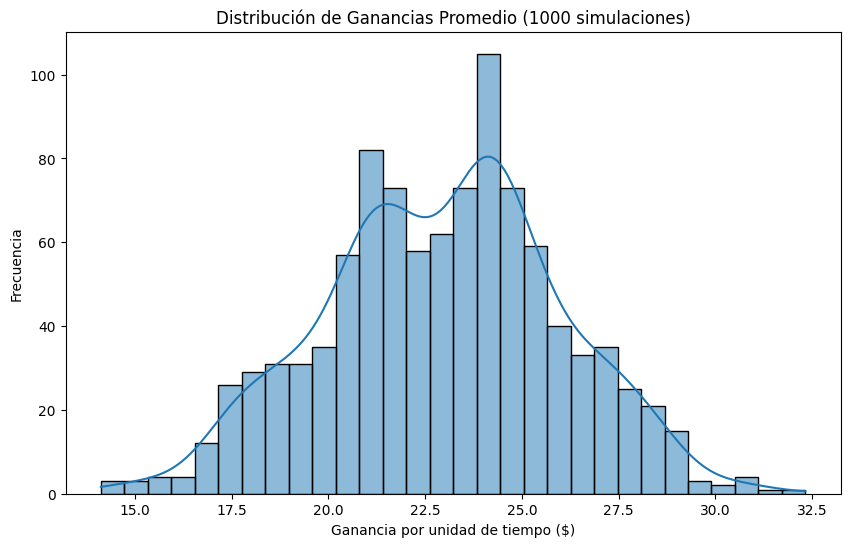

In [12]:
plt.figure(figsize=(10, 6))
sns.histplot(df["avg_profit"], kde=True, bins=30)
plt.title("Distribución de Ganancias Promedio (1000 simulaciones)")
plt.xlabel("Ganancia por unidad de tiempo ($)")
plt.ylabel("Frecuencia")
plt.show()

Gráfico 2: Relación entre Ingresos y Costos (Scatterplot de ingresos vs costos)

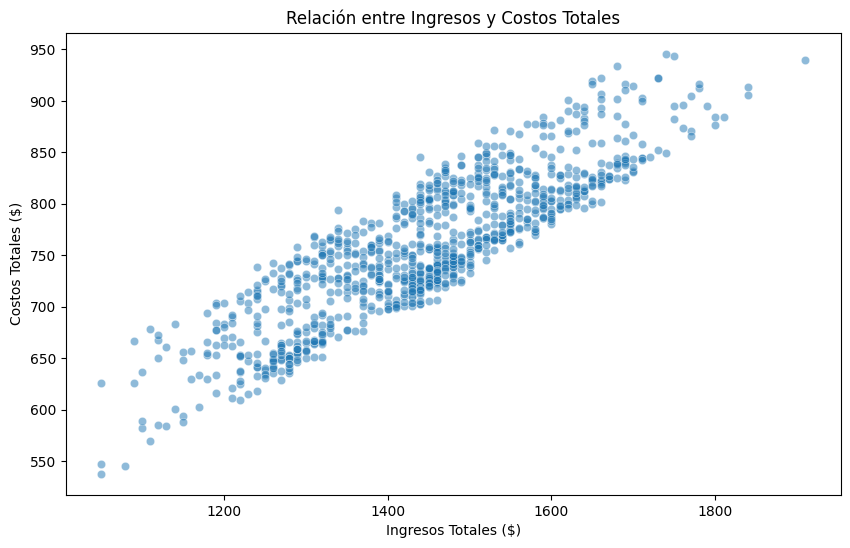

In [13]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="total_revenue", y="total_cost", alpha=0.5)
plt.title("Relación entre Ingresos y Costos Totales")
plt.xlabel("Ingresos Totales ($)")
plt.ylabel("Costos Totales ($)")
plt.show()

### 5. Experimentación con Diferentes Políticas (s, S)

Para comparar políticas, variamos s y S:

In [7]:
# Definir políticas a probar
# Nuevos rangos más amplios
s_values = list(range(1, 11))
S_values = list(range(15, 31))

# Resultados del experimento extendido
from scipy import stats

extended_results = []
n_replicas = 200

for s in s_values:
    for S in S_values:
        if s < S:
            params["s"], params["S"] = s, S
            runs = [run_simulation(params) for _ in range(n_replicas)]
            profits = [r["avg_profit"] for r in runs]
            mean = np.mean(profits)
            std = np.std(profits, ddof=1)
            ci_low, ci_high = stats.norm.interval(0.95, loc=mean, scale=std/np.sqrt(n_replicas))
            extended_results.append({
                "s": s, "S": S, "mean": mean,
                "std": std, "ci_low": ci_low, "ci_high": ci_high
            })

df_extended = pd.DataFrame(extended_results)

Se evalúan todas las combinaciones posibles de políticas (s, S) con $ s \in [1, 10] $ y $ S \in [15, 30] $, ejecutando 200 réplicas por política. Se calcula la media, desviación estándar y el intervalo de confianza del 95% para la ganancia promedio.

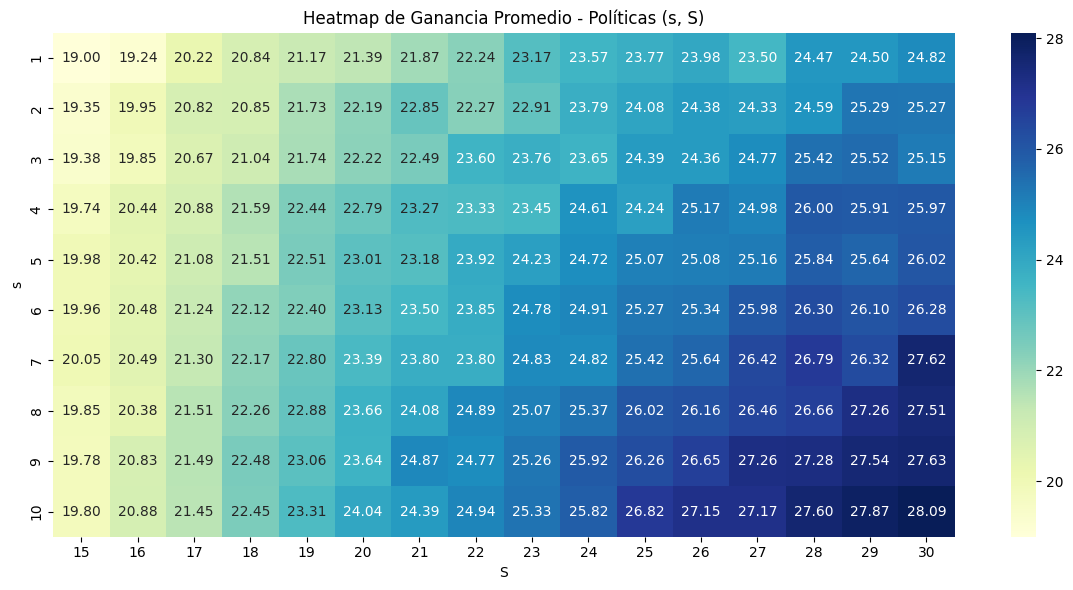

In [14]:
pivot_mean = df_extended.pivot(index="s", columns="S", values="mean")
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_mean, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Heatmap de Ganancia Promedio - Políticas (s, S)")
plt.xlabel("S")
plt.ylabel("s")
plt.tight_layout()
plt.show()


Mapa de calor con la ganancia promedio obtenida para cada combinación de política (s, S). Se puede observar claramente la tendencia creciente de la ganancia al aumentar los valores de S.

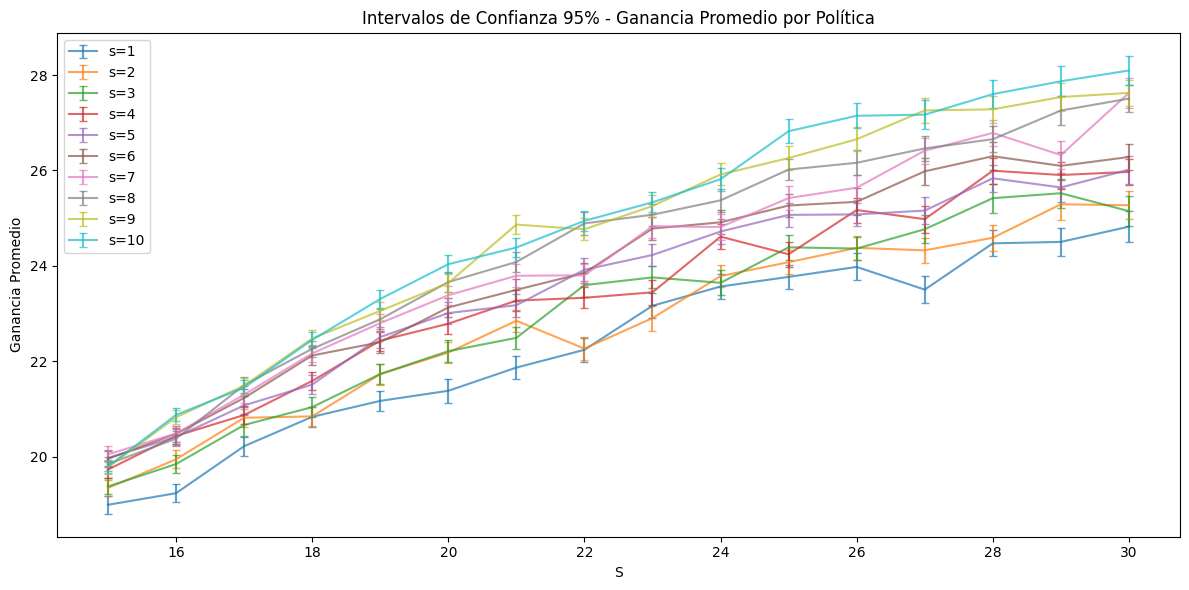

In [15]:
plt.figure(figsize=(12, 6))
for s_val in sorted(df_extended["s"].unique()):
    subset = df_extended[df_extended["s"] == s_val]
    plt.errorbar(subset["S"], subset["mean"], yerr=subset["std"]/np.sqrt(n_replicas),
                 capsize=3, label=f"s={s_val}", alpha=0.7)
plt.title("Intervalos de Confianza 95% - Ganancia Promedio por Política")
plt.xlabel("S")
plt.ylabel("Ganancia Promedio")
plt.legend()
plt.tight_layout()
plt.show()

Este gráfico muestra las ganancias promedio por política para distintos valores de s, con barras de error representando los intervalos de confianza del 95%.

In [10]:
top5 = df_extended.sort_values("mean", ascending=False).head(5)
print("Top 5 políticas según ganancia promedio:")
print(top5)

Top 5 políticas según ganancia promedio:
      s   S       mean       std     ci_low    ci_high
159  10  30  28.094725  4.371479  27.488880  28.700570
158  10  29  27.868739  4.410259  27.257519  28.479958
143   9  30  27.626049  3.930933  27.081259  28.170838
111   7  30  27.624861  4.444225  27.008934  28.240788
157  10  28  27.599753  4.072014  27.035411  28.164095
